In [128]:
%load_ext zipline
%load_ext watermark
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The zipline extension is already loaded. To reload it, use:
  %reload_ext zipline
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [129]:
import pandas as pd
import numpy as np
from collections import OrderedDict
import pytz

# необходимые функции zipline
from zipline.api import (order, record, symbol, set_benchmark, order_target_percent, get_open_orders, order_target, 
                        schedule_function, date_rules, time_rules, order_percent, symbols)

# комиссии
from zipline.finance import commission

# выбор календаря по которому происходит торговля
from trading_calendars.always_open import AlwaysOpenCalendar

import zipline

# графика
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

# работа с временем
from datetime import datetime, date

# aинансовые данные
from yahoofinancials import YahooFinancials

# ignore warnings
import warnings

# отчёт
import pyfolio as pf

# import helper functions 
import qf_helper_functions as qf

import pypfopt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

import pylab

from tqdm import tqdm

In [130]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [16, 4]
plt.rcParams['figure.dpi'] = 200
warnings.simplefilter(action='ignore', category=FutureWarning)

In [131]:
def download_csv_data(ticker, start_date, end_date, freq, path):
    
    yahoo_financials = YahooFinancials(ticker)

    df = yahoo_financials.get_historical_price_data(start_date, end_date, freq)
    df = pd.DataFrame(df[ticker]['prices']).drop(['date'], axis=1) \
            .rename(columns={'formatted_date':'date'}) \
            .loc[:, ['date','open','high','low','close', 'adjclose', 'volume']] \
            .set_index('date')
    df.index = pd.to_datetime(df.index)
    df['dividend'] = 0
    df['split'] = 1

    # save data to csv for later ingestion
    df.to_csv(path, header=True, index=True)

    # plot the time series
    df.close.plot(title='{} prices --- {}:{}'.format(ticker, start_date, end_date), color='green');

# Vanguard

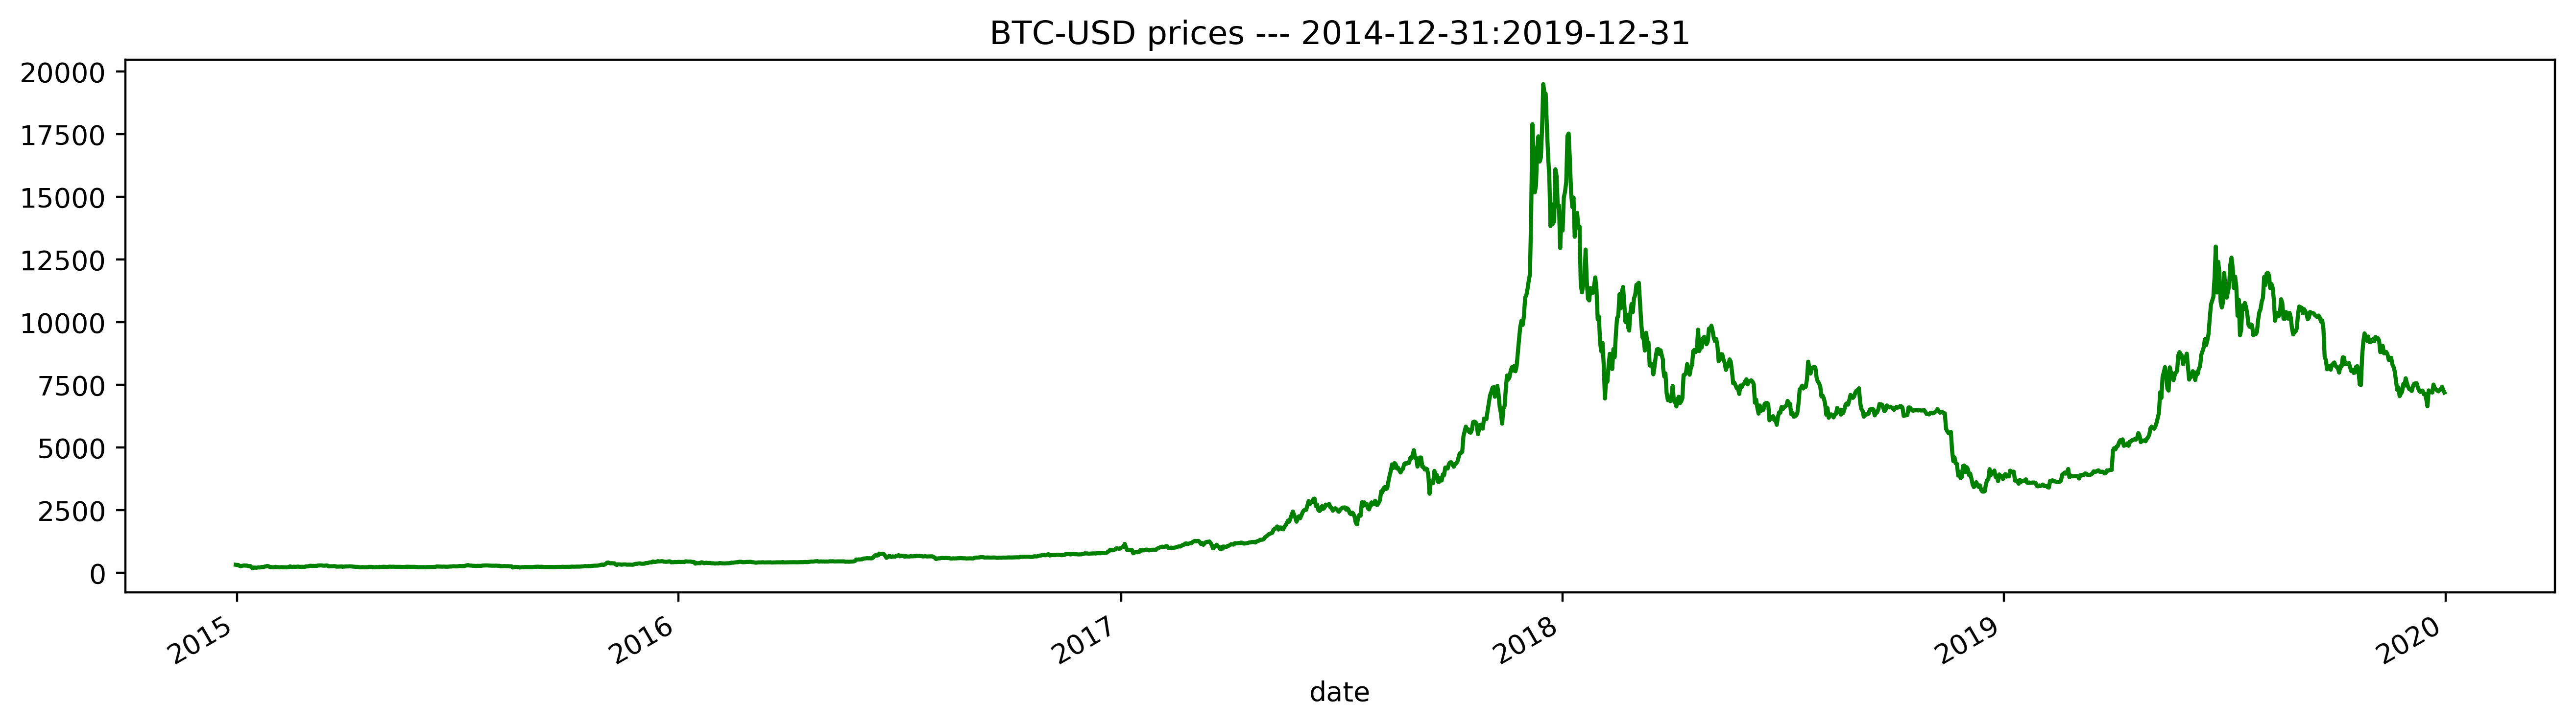

In [132]:
download_csv_data(ticker='BTC-USD', 
                  start_date='2014-12-31', 
                  end_date='2019-12-31', 
                  freq='daily', 
                  path='data/BTC.csv')

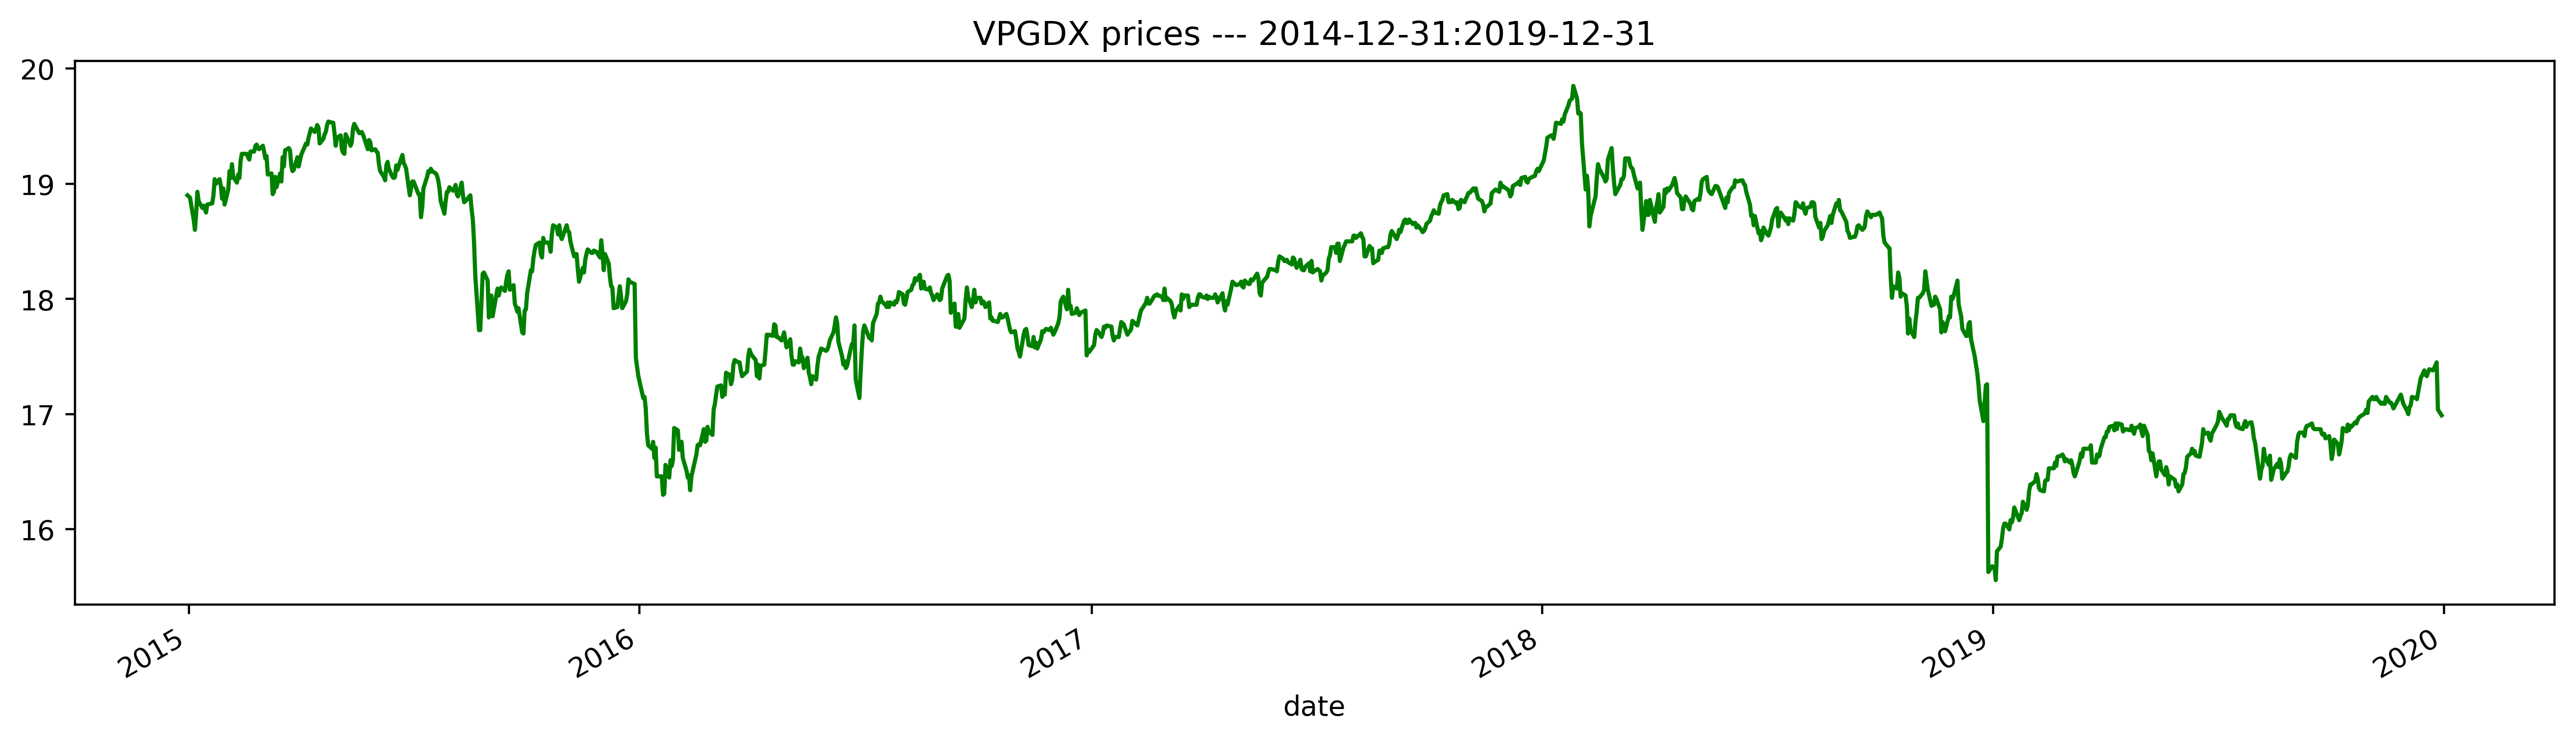

In [133]:
download_csv_data(ticker='VPGDX', 
                  start_date='2014-12-31', 
                  end_date='2019-12-31', 
                  freq='daily', 
                  path='data/VPGDX.csv')

# Симуляция с 5% BTC

In [134]:
# Список финансовых инструментов в портфеле
TIKERS = ['VPGDX', 'BTC']

# Данные которые будут использоваться в дальнейшем
COLUMNS = ['open', 'close', 'adjclose']

In [135]:
data = OrderedDict()

for tiker in TIKERS:
    data[tiker] = pd.read_csv("data/{}.csv".format(tiker), index_col=0, parse_dates=['date'])
    data[tiker] = data[tiker][COLUMNS]
    data[tiker] = data[tiker].resample("1d").mean()
    data[tiker].fillna(method="ffill", inplace=True)
    print(data[tiker].tail())

                 open      close   adjclose
date                                       
2019-12-26  17.450001  17.450001  17.008001
2019-12-27  17.040001  17.040001  17.040001
2019-12-28  17.040001  17.040001  17.040001
2019-12-29  17.040001  17.040001  17.040001
2019-12-30  16.990000  16.990000  16.990000
                   open        close     adjclose
date                                             
2019-12-27  7238.141113  7290.088379  7290.088379
2019-12-28  7289.031250  7317.990234  7317.990234
2019-12-29  7317.647461  7422.652832  7422.652832
2019-12-30  7420.272949  7292.995117  7292.995117
2019-12-31  7294.438965  7193.599121  7193.599121


In [136]:
for tiker in TIKERS:
    data[tiker]['close'] = data[tiker]['adjclose']
    data[tiker]['open'] = data[tiker]['adjclose']
    del data[tiker]['adjclose']
    print(data[tiker].tail())
COLUMNS = ['open', 'close']

                 open      close
date                            
2019-12-26  17.008001  17.008001
2019-12-27  17.040001  17.040001
2019-12-28  17.040001  17.040001
2019-12-29  17.040001  17.040001
2019-12-30  16.990000  16.990000
                   open        close
date                                
2019-12-27  7290.088379  7290.088379
2019-12-28  7317.990234  7317.990234
2019-12-29  7422.652832  7422.652832
2019-12-30  7292.995117  7292.995117
2019-12-31  7193.599121  7193.599121


In [137]:
panel = pd.Panel(data)
panel.minor_axis = COLUMNS
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)
print(panel)

<class 'pandas.core.panel.Panel'>
Dimensions: 2 (items) x 1827 (major_axis) x 2 (minor_axis)
Items axis: VPGDX to BTC
Major_axis axis: 2014-12-31 00:00:00+00:00 to 2019-12-31 00:00:00+00:00
Minor_axis axis: open to close


In [138]:
WEIGHTS = [0.94, 0.05]
COMMISSION = 0.001

In [139]:
def initialize(context):
    
    context.set_commission(commission.PerDollar(cost=COMMISSION))
    
    set_benchmark(symbol('VPGDX'))
    
    context.tikers = TIKERS
    context.assets = [context.symbol(symbol) for symbol in context.tikers]
    
    context.weights = WEIGHTS
    context.n_assets = len(context.assets)
    
    context.window = 1
    
    context.rebalance_period = 20
    context.time = 0

In [140]:
def handle_data(context, data):
    
    # Закупка и ребаллансировка
    if context.time == 0 or (context.time % context.rebalance_period == 0):
        
        
        # submit orders
        for i, asset in enumerate(context.assets):
            order_target_percent(asset, context.weights[i])
            
    
    context.time += 1

In [141]:
perf = zipline.run_algorithm(start=datetime(2014, 12, 31, 0, 0, 0, 0, pytz.utc),
                              end=datetime(2019, 12, 31, 0, 0, 0, 0, pytz.utc),
                              initialize=initialize,
                              capital_base=10000000,
                              handle_data=handle_data,
                              data=panel)

In [142]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)

In [143]:
qf.get_performance_summary(returns)

annual_volatility     0.077316
annualized_returns    0.108938
cumulative_returns    0.676325
max_drawdown         -0.137359
sharpe_ratio          1.376346
sortino_ratio         1.999997
dtype: float64

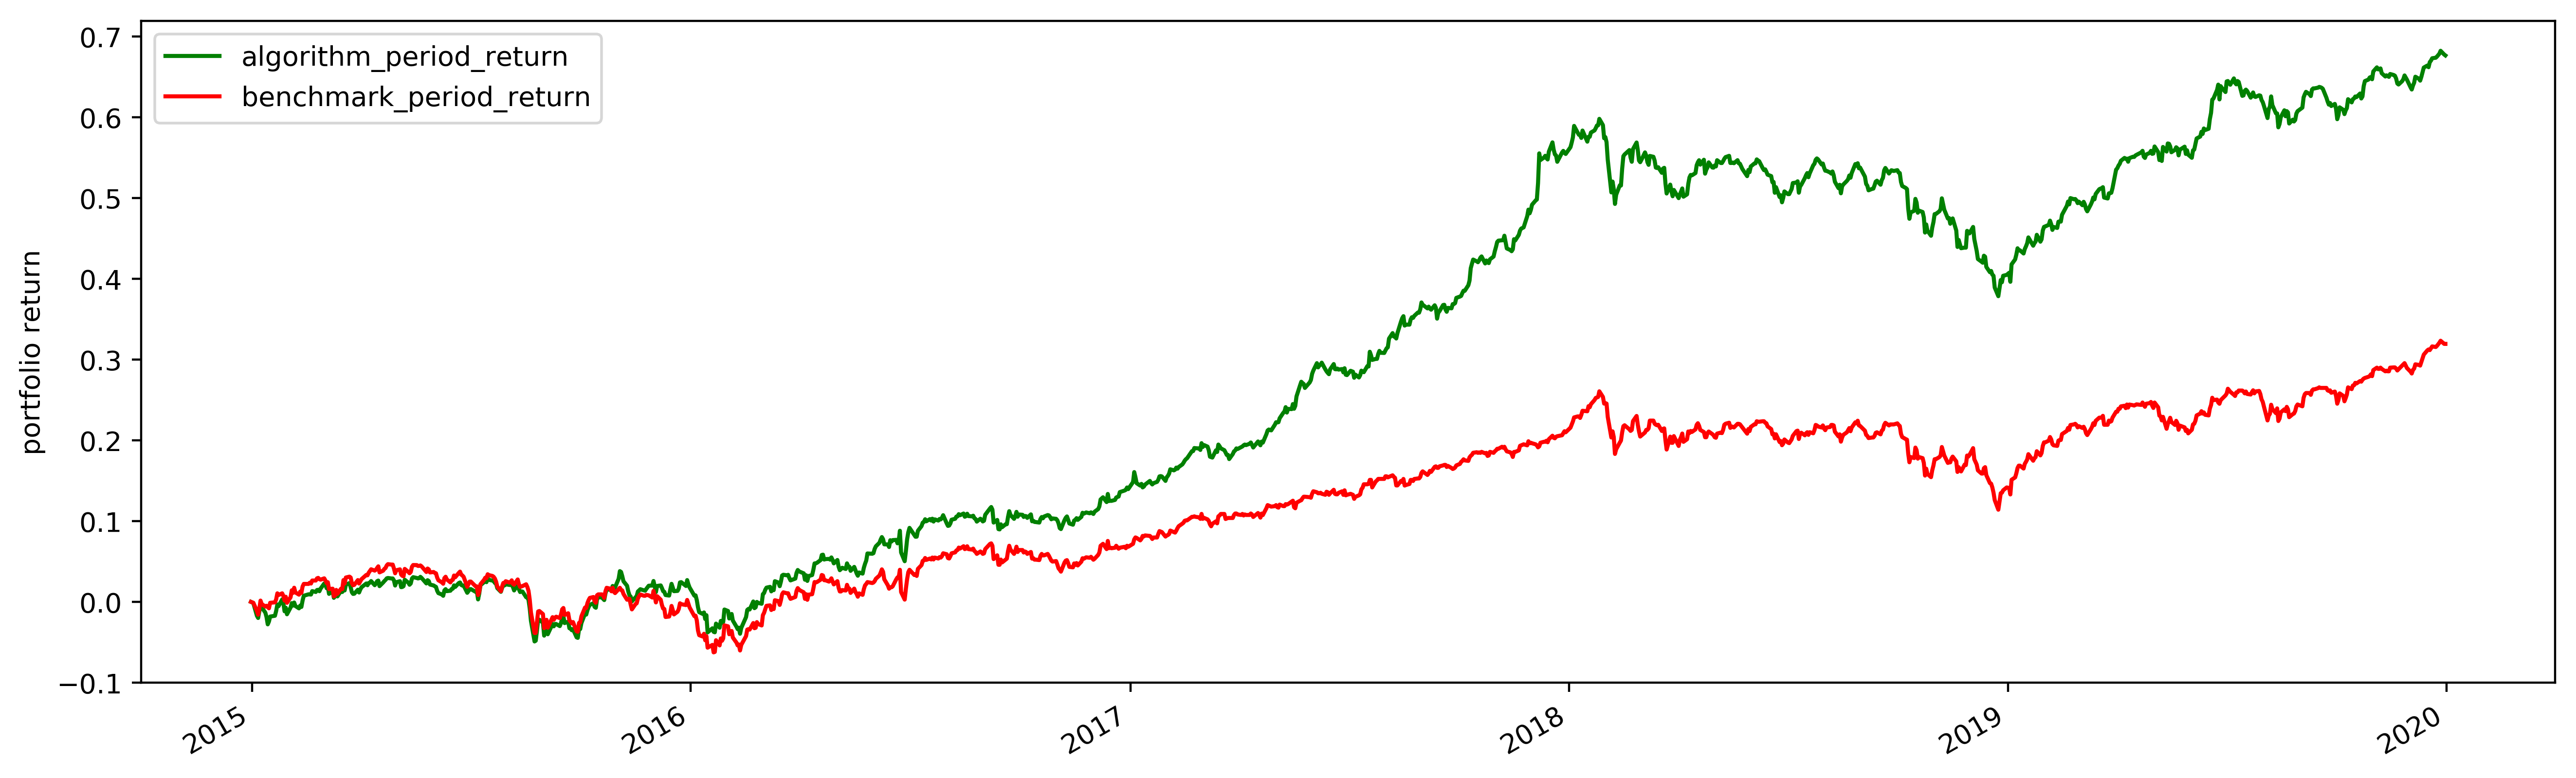

Final portfolio return: 67.63%
Final benchmark return: 31.93%


In [144]:
fig, ax = plt.subplots(figsize=[16, 5])

# portfolio value
perf.algorithm_period_return.plot(color='g')
perf.benchmark_period_return.plot(color='r')

ax.set_ylabel('portfolio return')

plt.legend()
plt.show()

print('Final portfolio return: {}%'.format(np.round(perf.algorithm_period_return[-1] * 100, 2)))
print('Final benchmark return: {}%'.format(np.round(perf.benchmark_period_return[-1] * 100, 2)))

In [145]:
(perf.portfolio_value/100000).tail()

2019-12-24 00:00:00+00:00    167.492523
2019-12-26 00:00:00+00:00    167.851062
2019-12-27 00:00:00+00:00    168.206251
2019-12-30 00:00:00+00:00    167.744797
2019-12-31 00:00:00+00:00    167.632479
Name: portfolio_value, dtype: float64

In [146]:
bitcoin5 = perf.algorithm_period_return

In [147]:
bitcoinPortfolio5 = 1000 * (1 + bitcoin5)

bitcoinPortfolio5 = bitcoinPortfolio5.rename('BTC 5% Target') 

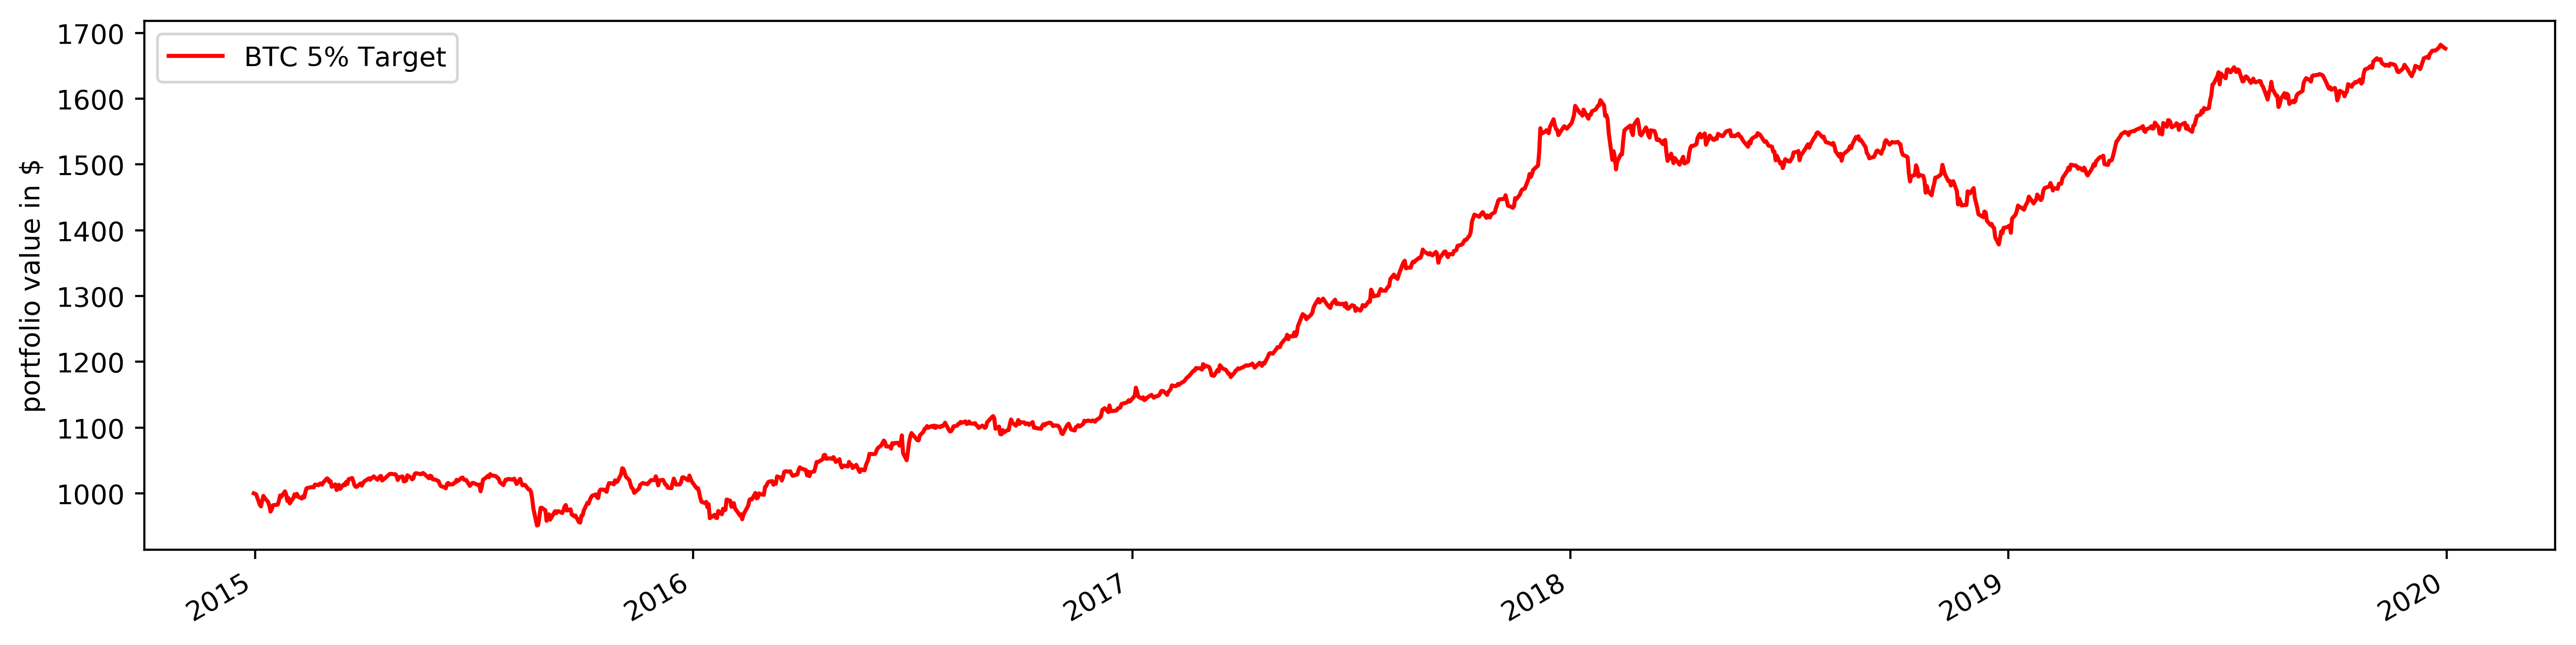

In [148]:
fig, ax = plt.subplots(figsize=[16, 4])

# portfolio value
bitcoinPortfolio5.plot(color='r')
#portfolio1.plot(color='gold')
#vanguard.plot(color='gray')

ax.set_ylabel('portfolio value in $')

plt.legend()
plt.show()

In [149]:
#Поправляем индексацию

new_index = pd.Series(pd.to_datetime(positions.index).date).map(lambda x: x.strftime('%Y-%m-%d'))
weights_df = pd.DataFrame.from_records(positions, index=new_index)
weights_df.head()

sid         Equity(0 [BTC])  Equity(1 [VPGDX])           cash
2015-01-02    491764.972198       9.390050e+06  103357.204546
2015-01-05    428453.912476       9.295554e+06  103357.204546
2015-01-06    446741.021759       9.250791e+06  103357.204546
2015-01-07    459460.065765       9.320420e+06  103357.204546
2015-01-08    442307.787476       9.414923e+06  103357.204546

In [150]:
# Поправляем названия столбцов

weights_df.columns = ['BTC', 'VPGDX', 'Cash']

In [151]:
# Нормирование весов в файле

norm_weights_df = weights_df.copy()

norm_weights_df['BTC'] = weights_df['BTC']/(weights_df['BTC'] + weights_df['VPGDX'] + weights_df['Cash'])    
norm_weights_df['VPGDX'] = weights_df['VPGDX']/(weights_df['VPGDX'] + weights_df['BTC'] + weights_df['Cash'])
norm_weights_df['Cash'] = weights_df['Cash']/(weights_df['VPGDX'] + weights_df['BTC'] + weights_df['Cash'])

In [152]:
# convert date objects from pandas format to python datetime
norm_weights_df.index = [pd.to_datetime(date, format='%Y-%m-%d').date() for date in norm_weights_df.index]

In [153]:
norm_weights_df.tail()

BTC     VPGDX      Cash
2019-12-24  0.049402  0.941111  0.009487
2019-12-26  0.048734  0.941800  0.009467
2019-12-27  0.048974  0.941579  0.009447
2019-12-30  0.049129  0.941399  0.009473
2019-12-31  0.048492  0.942030  0.009479

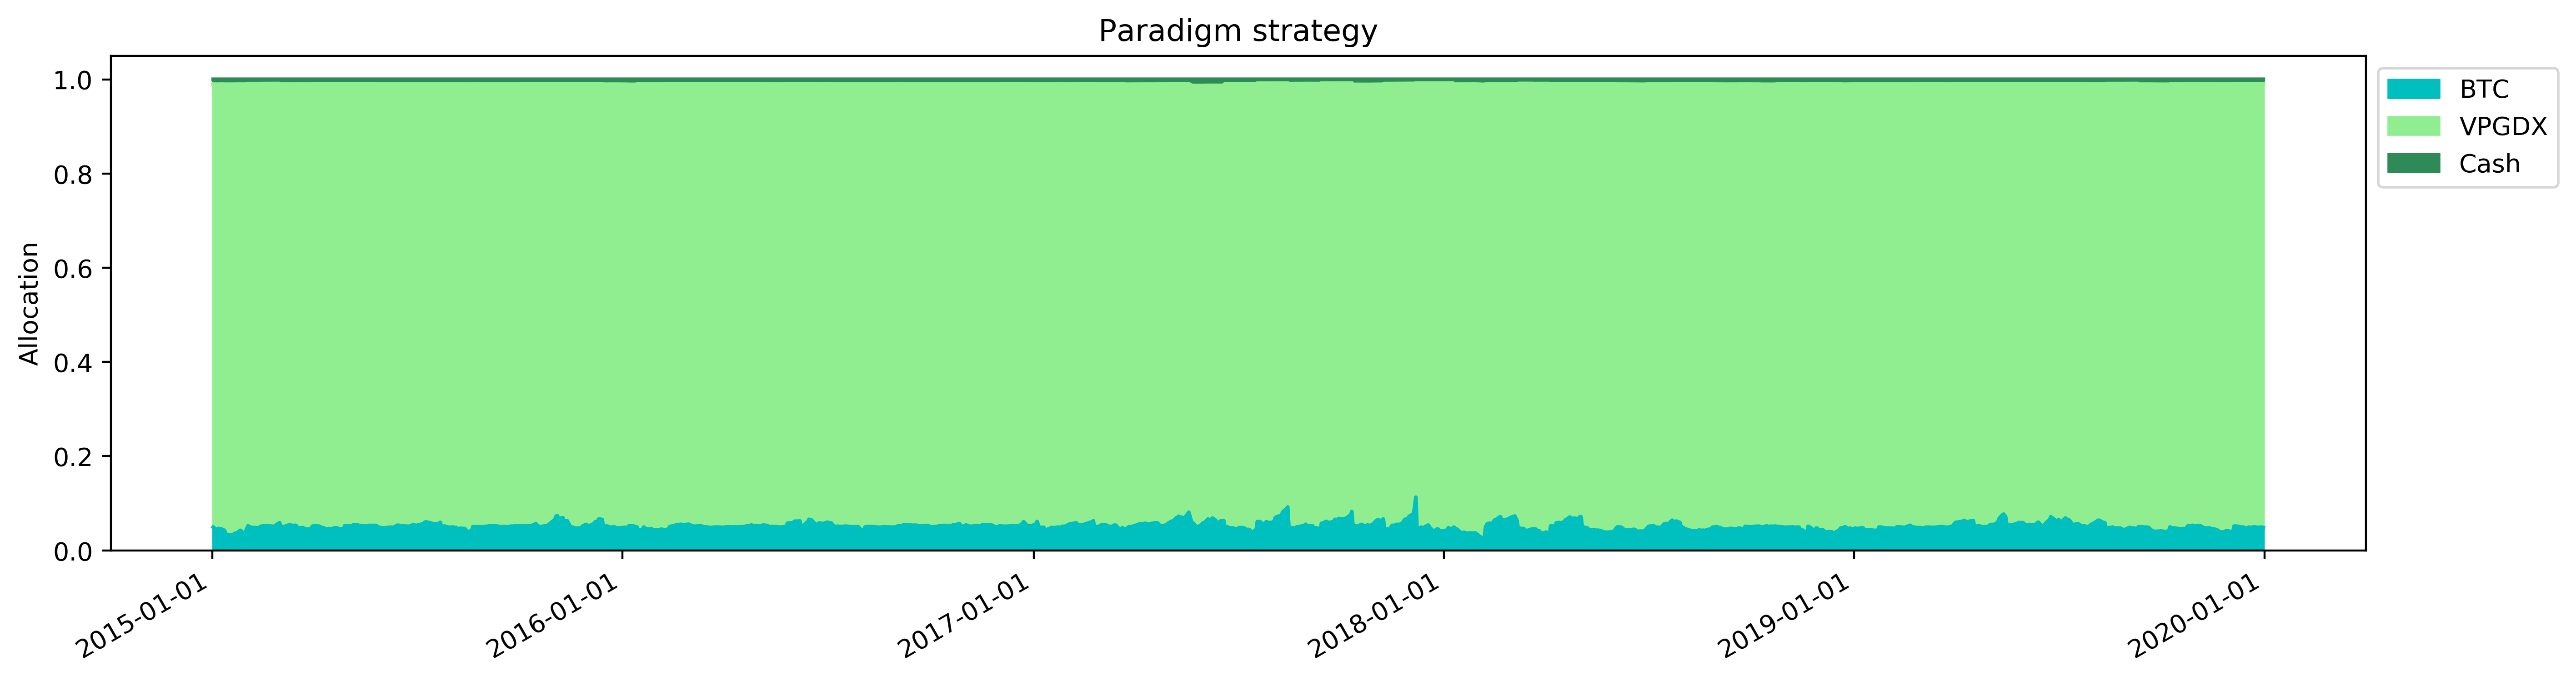

In [154]:
norm_weights_df = norm_weights_df[['BTC', 'VPGDX', 'Cash']]
# plot the results
col = ['c', 'lightgreen', 'seagreen']
ax = norm_weights_df.plot(kind='area', stacked=True, color = col) # stacked=True показывает веса в одном столбце

# set monthly locator

##### Градуировка https://matplotlib.org/3.1.0/gallery/ticks_and_spines/tick-locators.html
#ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
# set formatter
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# set font and rotation for date tick labels
plt.gcf().autofmt_xdate()

ax.tick_params(axis = 'both', direction = 'out')
ax.set(title = 'Paradigm strategy', ylabel='Allocation')
ax.legend(bbox_to_anchor=(1,1))
plt.show()

# Симуляция с 1% Bitcoin

In [155]:
# Список финансовых инструментов в портфеле
TIKERS = ['VPGDX', 'BTC']

# Данные которые будут использоваться в дальнейшем
COLUMNS = ['open', 'close', 'adjclose']

In [156]:
data = OrderedDict()

for tiker in TIKERS:
    data[tiker] = pd.read_csv("data/{}.csv".format(tiker), index_col=0, parse_dates=['date'])
    data[tiker] = data[tiker][COLUMNS]
    data[tiker] = data[tiker].resample("1d").mean()
    data[tiker].fillna(method="ffill", inplace=True)
    print(data[tiker].head())

                 open      close   adjclose
date                                       
2014-12-31  18.900000  18.900000  12.877502
2015-01-01  18.900000  18.900000  12.877502
2015-01-02  18.879999  18.879999  12.863875
2015-01-03  18.879999  18.879999  12.863875
2015-01-04  18.879999  18.879999  12.863875
                  open       close    adjclose
date                                          
2014-12-31  310.914001  320.192993  320.192993
2015-01-01  320.434998  314.248993  314.248993
2015-01-02  314.079010  315.032013  315.032013
2015-01-03  314.846008  281.082001  281.082001
2015-01-04  281.145996  264.195007  264.195007


In [157]:
for tiker in TIKERS:
    data[tiker]['close'] = data[tiker]['adjclose']
    data[tiker]['open'] = data[tiker]['adjclose']
    del data[tiker]['adjclose']
    print(data[tiker].tail())
COLUMNS = ['open', 'close']

                 open      close
date                            
2019-12-26  17.008001  17.008001
2019-12-27  17.040001  17.040001
2019-12-28  17.040001  17.040001
2019-12-29  17.040001  17.040001
2019-12-30  16.990000  16.990000
                   open        close
date                                
2019-12-27  7290.088379  7290.088379
2019-12-28  7317.990234  7317.990234
2019-12-29  7422.652832  7422.652832
2019-12-30  7292.995117  7292.995117
2019-12-31  7193.599121  7193.599121


In [158]:
panel = pd.Panel(data)
panel.minor_axis = COLUMNS
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)
print(panel)

<class 'pandas.core.panel.Panel'>
Dimensions: 2 (items) x 1827 (major_axis) x 2 (minor_axis)
Items axis: VPGDX to BTC
Major_axis axis: 2014-12-31 00:00:00+00:00 to 2019-12-31 00:00:00+00:00
Minor_axis axis: open to close


In [159]:
WEIGHTS = [0.98, 0.01]
COMMISSION = 0.001

In [160]:
def initialize(context):
    
    context.set_commission(commission.PerDollar(cost=COMMISSION))
    
    set_benchmark(symbol('VPGDX'))
    
    context.tikers = TIKERS
    context.assets = [context.symbol(symbol) for symbol in context.tikers]
    
    context.weights = WEIGHTS
    context.n_assets = len(context.assets)
    
    context.window = 1
    
    context.rebalance_period = 20
    context.time = 0

In [161]:
def handle_data(context, data):
    
    # Закупка и ребаллансировка
    if context.time == 0 or (context.time % context.rebalance_period == 0):
        
        
        # submit orders
        for i, asset in enumerate(context.assets):
            order_target_percent(asset, context.weights[i])
            
    
    context.time += 1

In [162]:
perf = zipline.run_algorithm(start=datetime(2014, 12, 31, 0, 0, 0, 0, pytz.utc),
                              end=datetime(2019, 12, 31, 0, 0, 0, 0, pytz.utc),
                              initialize=initialize,
                              capital_base=10000000,
                              handle_data=handle_data,
                              data=panel)

In [163]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)

In [164]:
qf.get_performance_summary(returns)

annual_volatility     0.070291
annualized_returns    0.067012
cumulative_returns    0.382722
max_drawdown         -0.119543
sharpe_ratio          0.958053
sortino_ratio         1.338760
dtype: float64

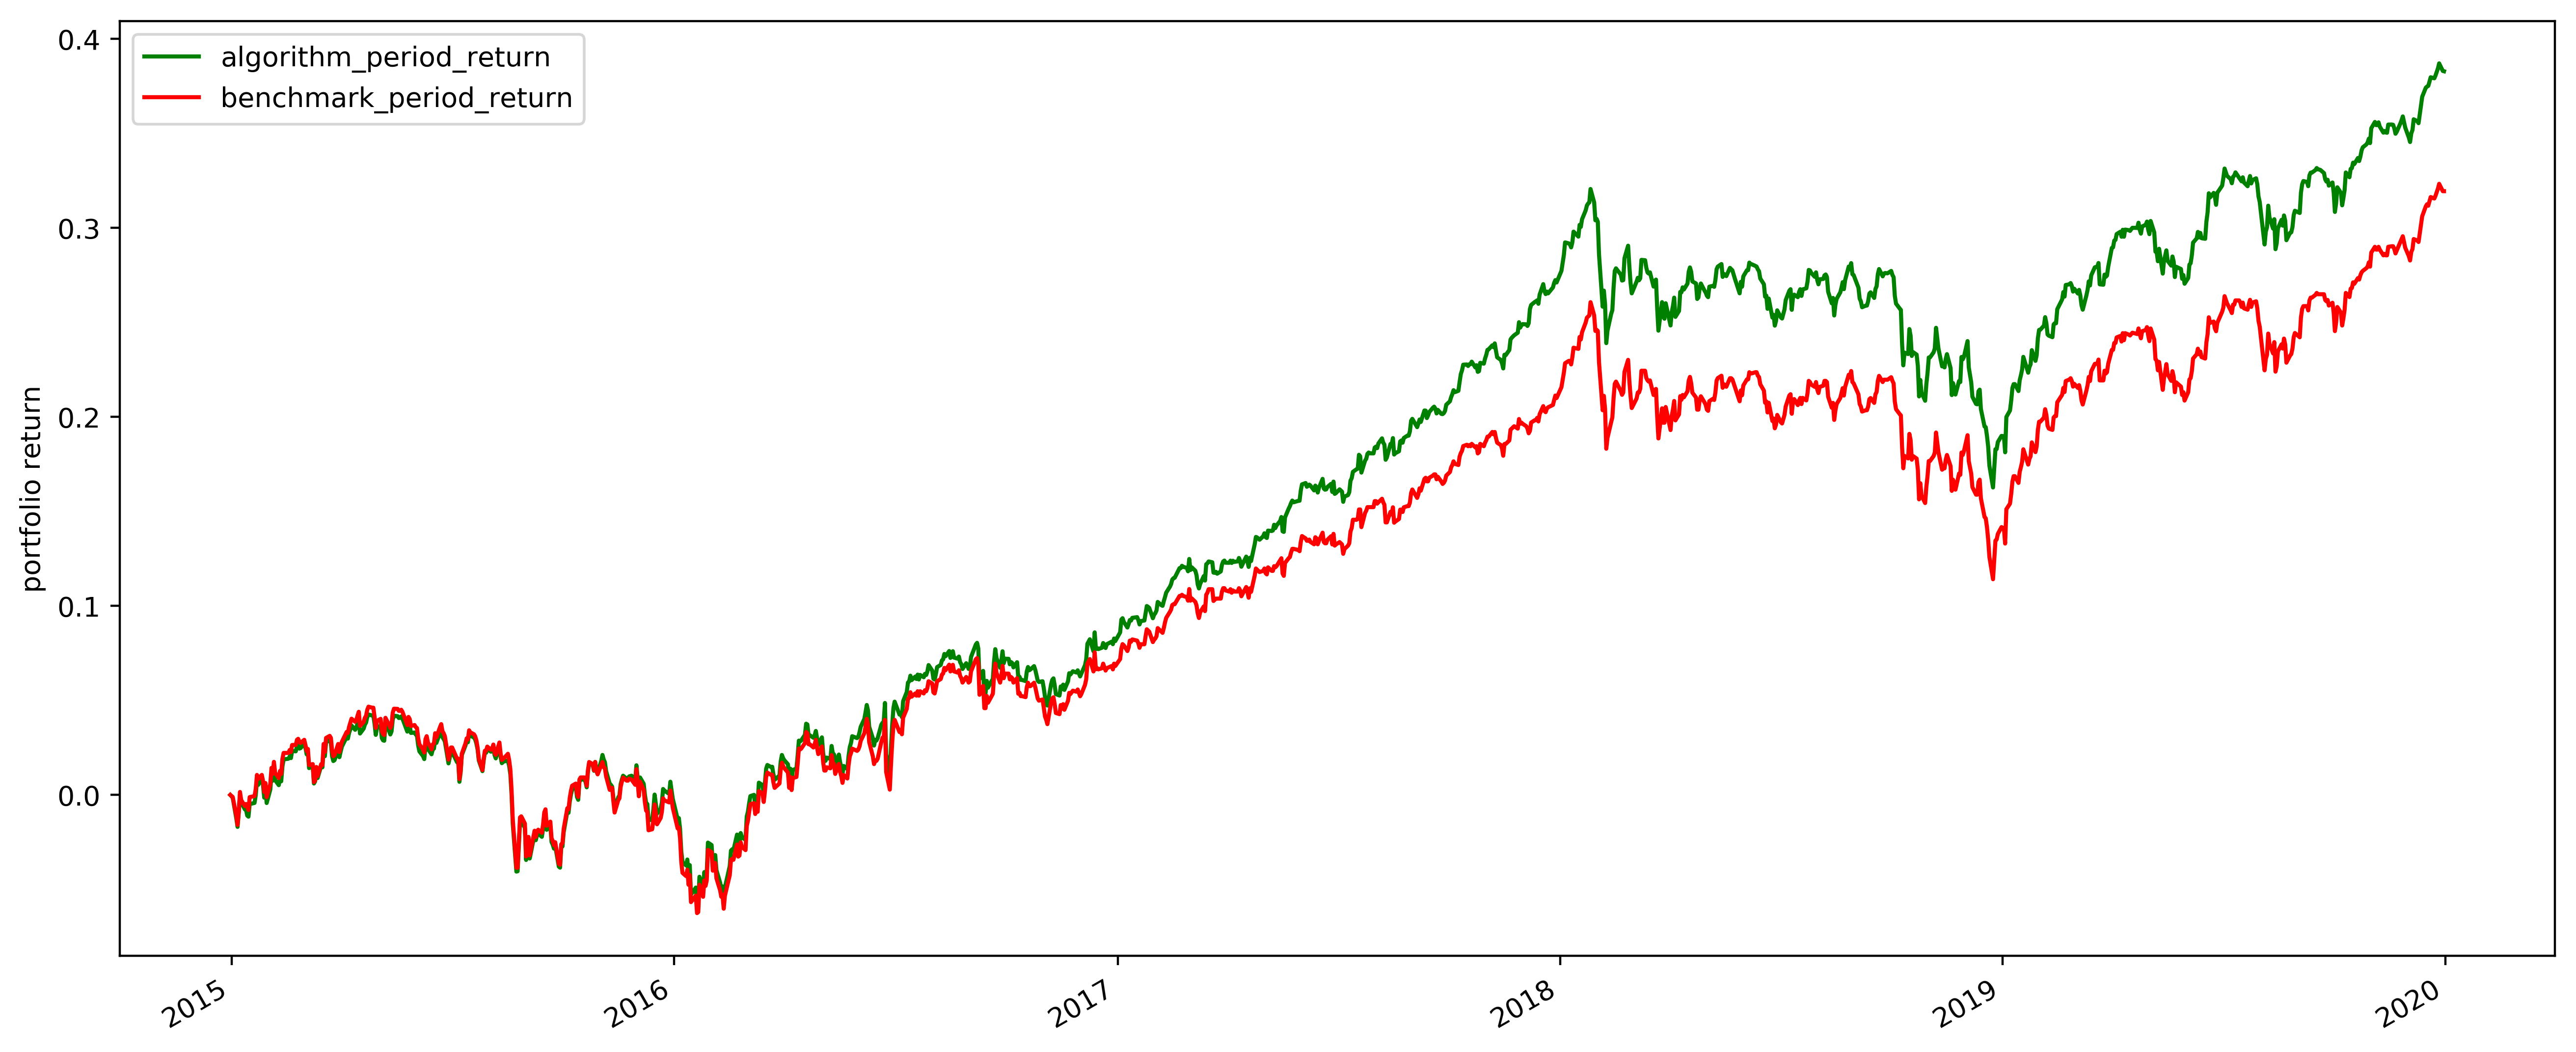

Final portfolio return: 38.27%
Final benchmark return: 31.93%


In [165]:
fig, ax = plt.subplots(figsize=[16, 7])

# portfolio value
perf.algorithm_period_return.plot(color='g')
perf.benchmark_period_return.plot(color='r')

ax.set_ylabel('portfolio return')

plt.legend()
plt.show()

print('Final portfolio return: {}%'.format(np.round(perf.algorithm_period_return[-1] * 100, 2)))
print('Final benchmark return: {}%'.format(np.round(perf.benchmark_period_return[-1] * 100, 2)))

In [166]:
bitcoin1 = perf.algorithm_period_return

In [167]:
vanguard = perf.benchmark_period_return

In [168]:
bitcoinPortfolio1 = 1000 * (1 + bitcoin1)
benchmark = 1000 * (1 + vanguard)

bitcoinPortfolio1 = bitcoinPortfolio1.rename('BTC 1% Target')
benchmark = benchmark.rename('No BTC') 

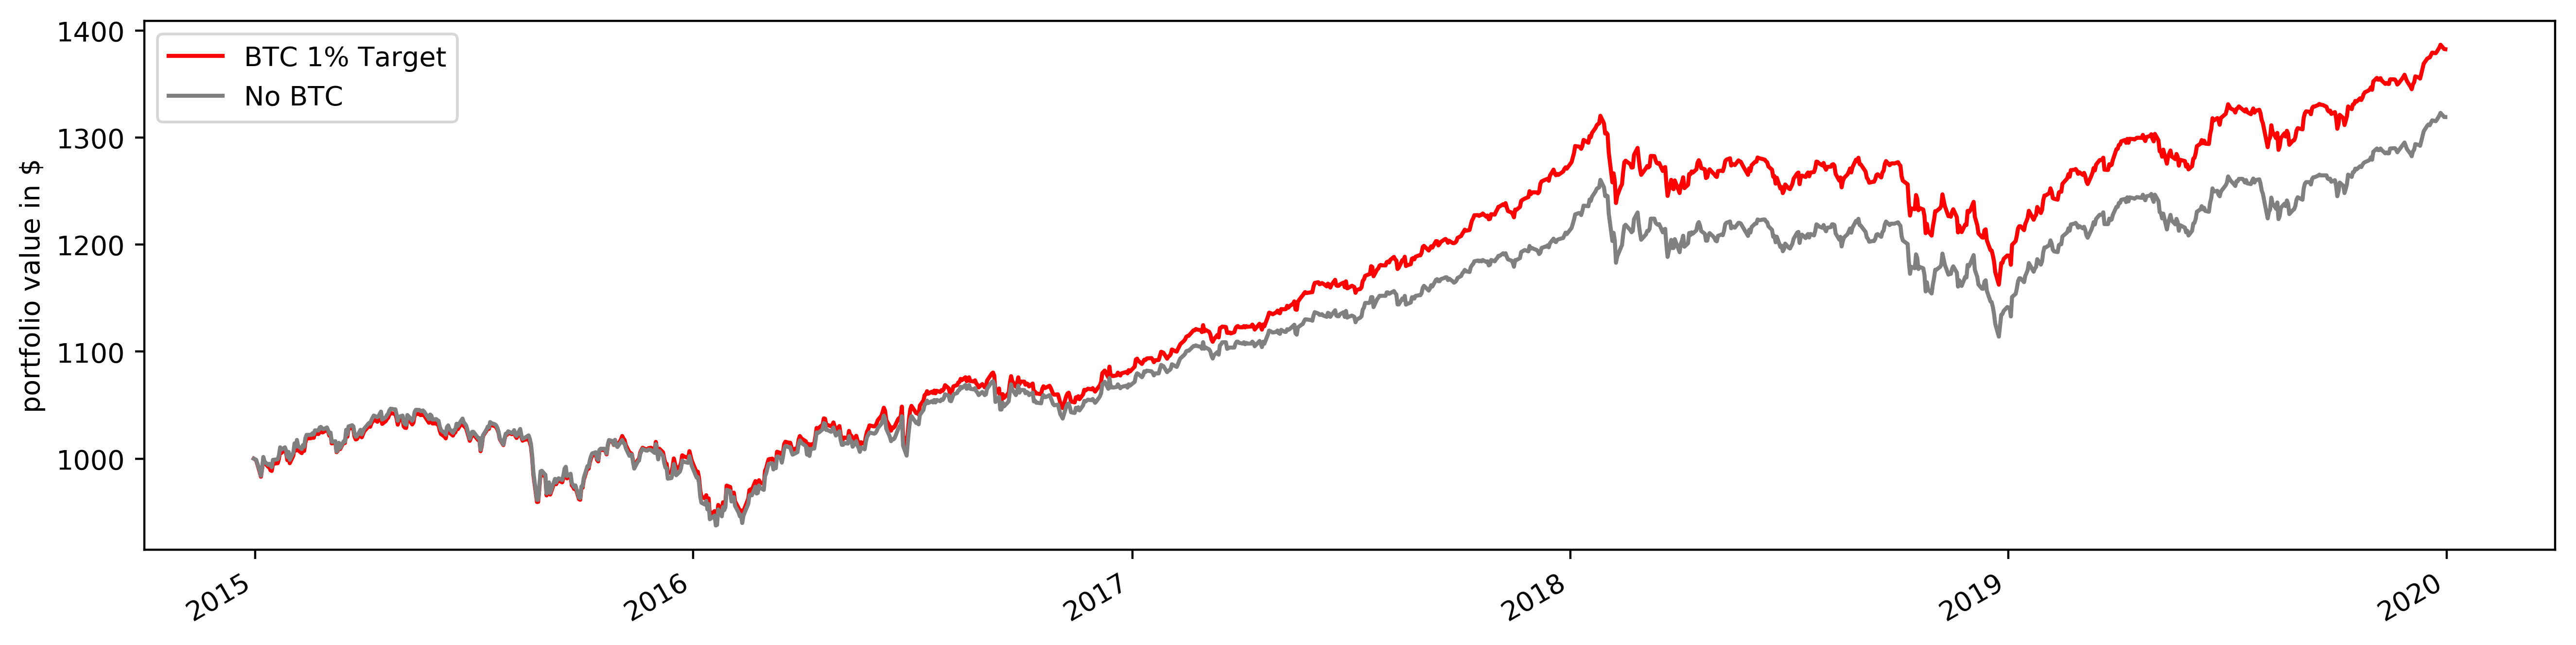

In [169]:
fig, ax = plt.subplots(figsize=[16, 4])

# portfolio value
bitcoinPortfolio1.plot(color='r')
benchmark.plot(color='gray')

ax.set_ylabel('portfolio value in $')

plt.legend()
plt.show()

In [170]:
#Поправляем индексацию

new_index = pd.Series(pd.to_datetime(positions.index).date).map(lambda x: x.strftime('%Y-%m-%d'))
weights_df = pd.DataFrame.from_records(positions, index=new_index)
weights_df.tail()

sid         Equity(0 [BTC])  Equity(1 [VPGDX])           cash
2019-12-24    131805.580078       1.353441e+07  138799.529093
2019-12-26    130301.402344       1.357330e+07  138799.529093
2019-12-27    131221.590820       1.359884e+07  138799.529093
2019-12-30    131273.912109       1.355894e+07  138799.529093
2019-12-31    129484.784180       1.355894e+07  138799.529093

In [171]:
# Поправляем названия столбцов

weights_df.columns = ['BTC', 'VPGDX', 'Cash']

In [172]:
# Нормирование весов в файле

norm_weights_df = weights_df.copy()

norm_weights_df['BTC'] = weights_df['BTC']/(weights_df['BTC'] + weights_df['VPGDX'] + weights_df['Cash'])    
norm_weights_df['VPGDX'] = weights_df['VPGDX']/(weights_df['VPGDX'] + weights_df['BTC'] + weights_df['Cash'])
norm_weights_df['Cash'] = weights_df['Cash']/(weights_df['VPGDX'] + weights_df['BTC'] + weights_df['Cash'])

In [173]:
# convert date objects from pandas format to python datetime
norm_weights_df.index = [pd.to_datetime(date, format='%Y-%m-%d').date() for date in norm_weights_df.index]

In [174]:
norm_weights_df.tail()

BTC     VPGDX      Cash
2019-12-24  0.009548  0.980398  0.010054
2019-12-26  0.009413  0.980560  0.010027
2019-12-27  0.009462  0.980530  0.010008
2019-12-30  0.009493  0.980471  0.010037
2019-12-31  0.009364  0.980597  0.010038

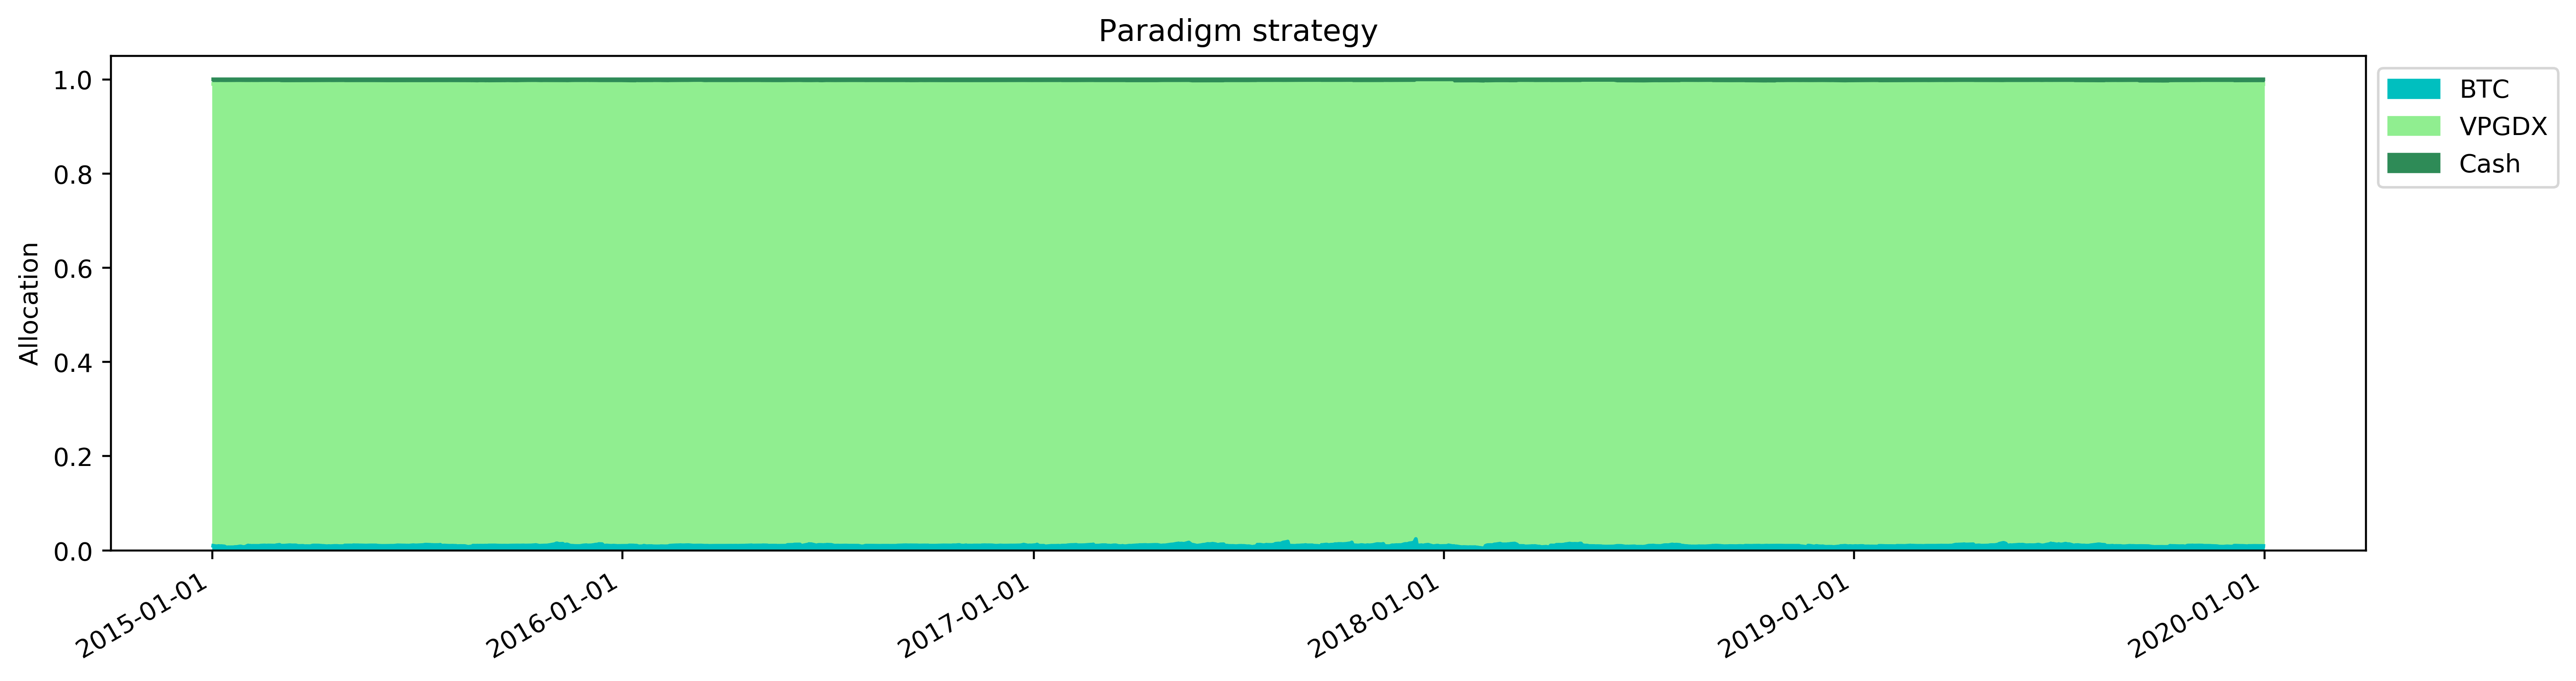

In [175]:
norm_weights_df = norm_weights_df[['BTC', 'VPGDX', 'Cash']]
# plot the results
col = ['c', 'lightgreen', 'seagreen']
ax = norm_weights_df.plot(kind='area', stacked=True, color = col) # stacked=True показывает веса в одном столбце

# set monthly locator

##### Градуировка https://matplotlib.org/3.1.0/gallery/ticks_and_spines/tick-locators.html
#ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
# set formatter
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# set font and rotation for date tick labels
plt.gcf().autofmt_xdate()

ax.tick_params(axis = 'both', direction = 'out')
ax.set(title = 'Paradigm strategy', ylabel='Allocation')
ax.legend(bbox_to_anchor=(1,1))
plt.show()

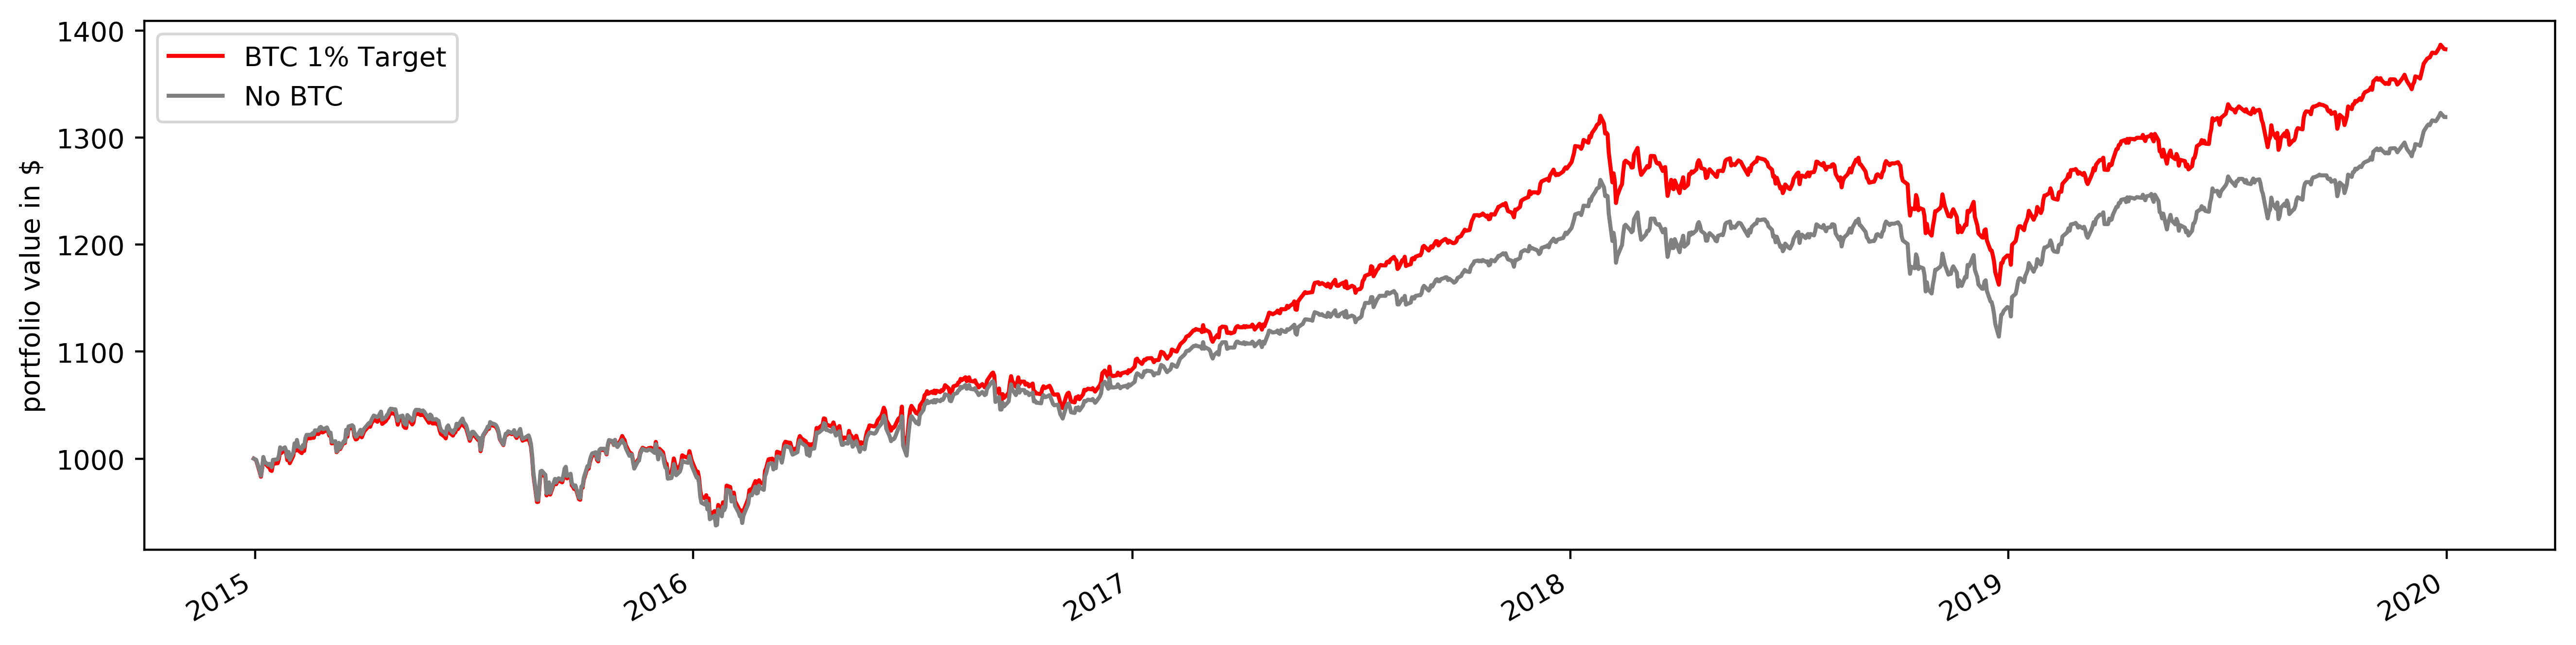

In [176]:
fig, ax = plt.subplots(figsize=[16, 4])

# portfolio value
#bitcoinPortfolio5.plot(color='gold')
bitcoinPortfolio1.plot(color='r')
benchmark.plot(color='gray')

ax.set_ylabel('portfolio value in $')

plt.legend()
plt.show()

In [177]:
fig.savefig('vanguard.png', transparent=False, dpi=300, bbox_inches="tight")

# Просадки

In [178]:
window = 365

In [179]:
# Calculate the max drawdown in the past window days for each day in the series.
# Use min_periods=1 if you want to let the first 365 days data have an expanding window
Roll_Max1 = pd.rolling_max(bitcoinPortfolio1, window, min_periods=1)
Roll_Max2 = pd.rolling_max(bitcoinPortfolio5, window, min_periods=1)
Roll_Max3 = pd.rolling_max(benchmark, window, min_periods=1)
Daily_Drawdown1 = bitcoinPortfolio1/Roll_Max1 - 1.0
Daily_Drawdown2 = bitcoinPortfolio5/Roll_Max2 - 1.0
Daily_Drawdown3 = benchmark/Roll_Max3 - 1.0

In [180]:
# Next we calculate the minimum (negative) daily drawdown in that window.
# Again, use min_periods=1 if you want to allow the expanding window
Max_Daily_Drawdown1 = pd.rolling_min(Daily_Drawdown1, window, min_periods=1)
Max_Daily_Drawdown2 = pd.rolling_min(Daily_Drawdown2, window, min_periods=1)
Max_Daily_Drawdown3 = pd.rolling_min(Daily_Drawdown3, window, min_periods=1)

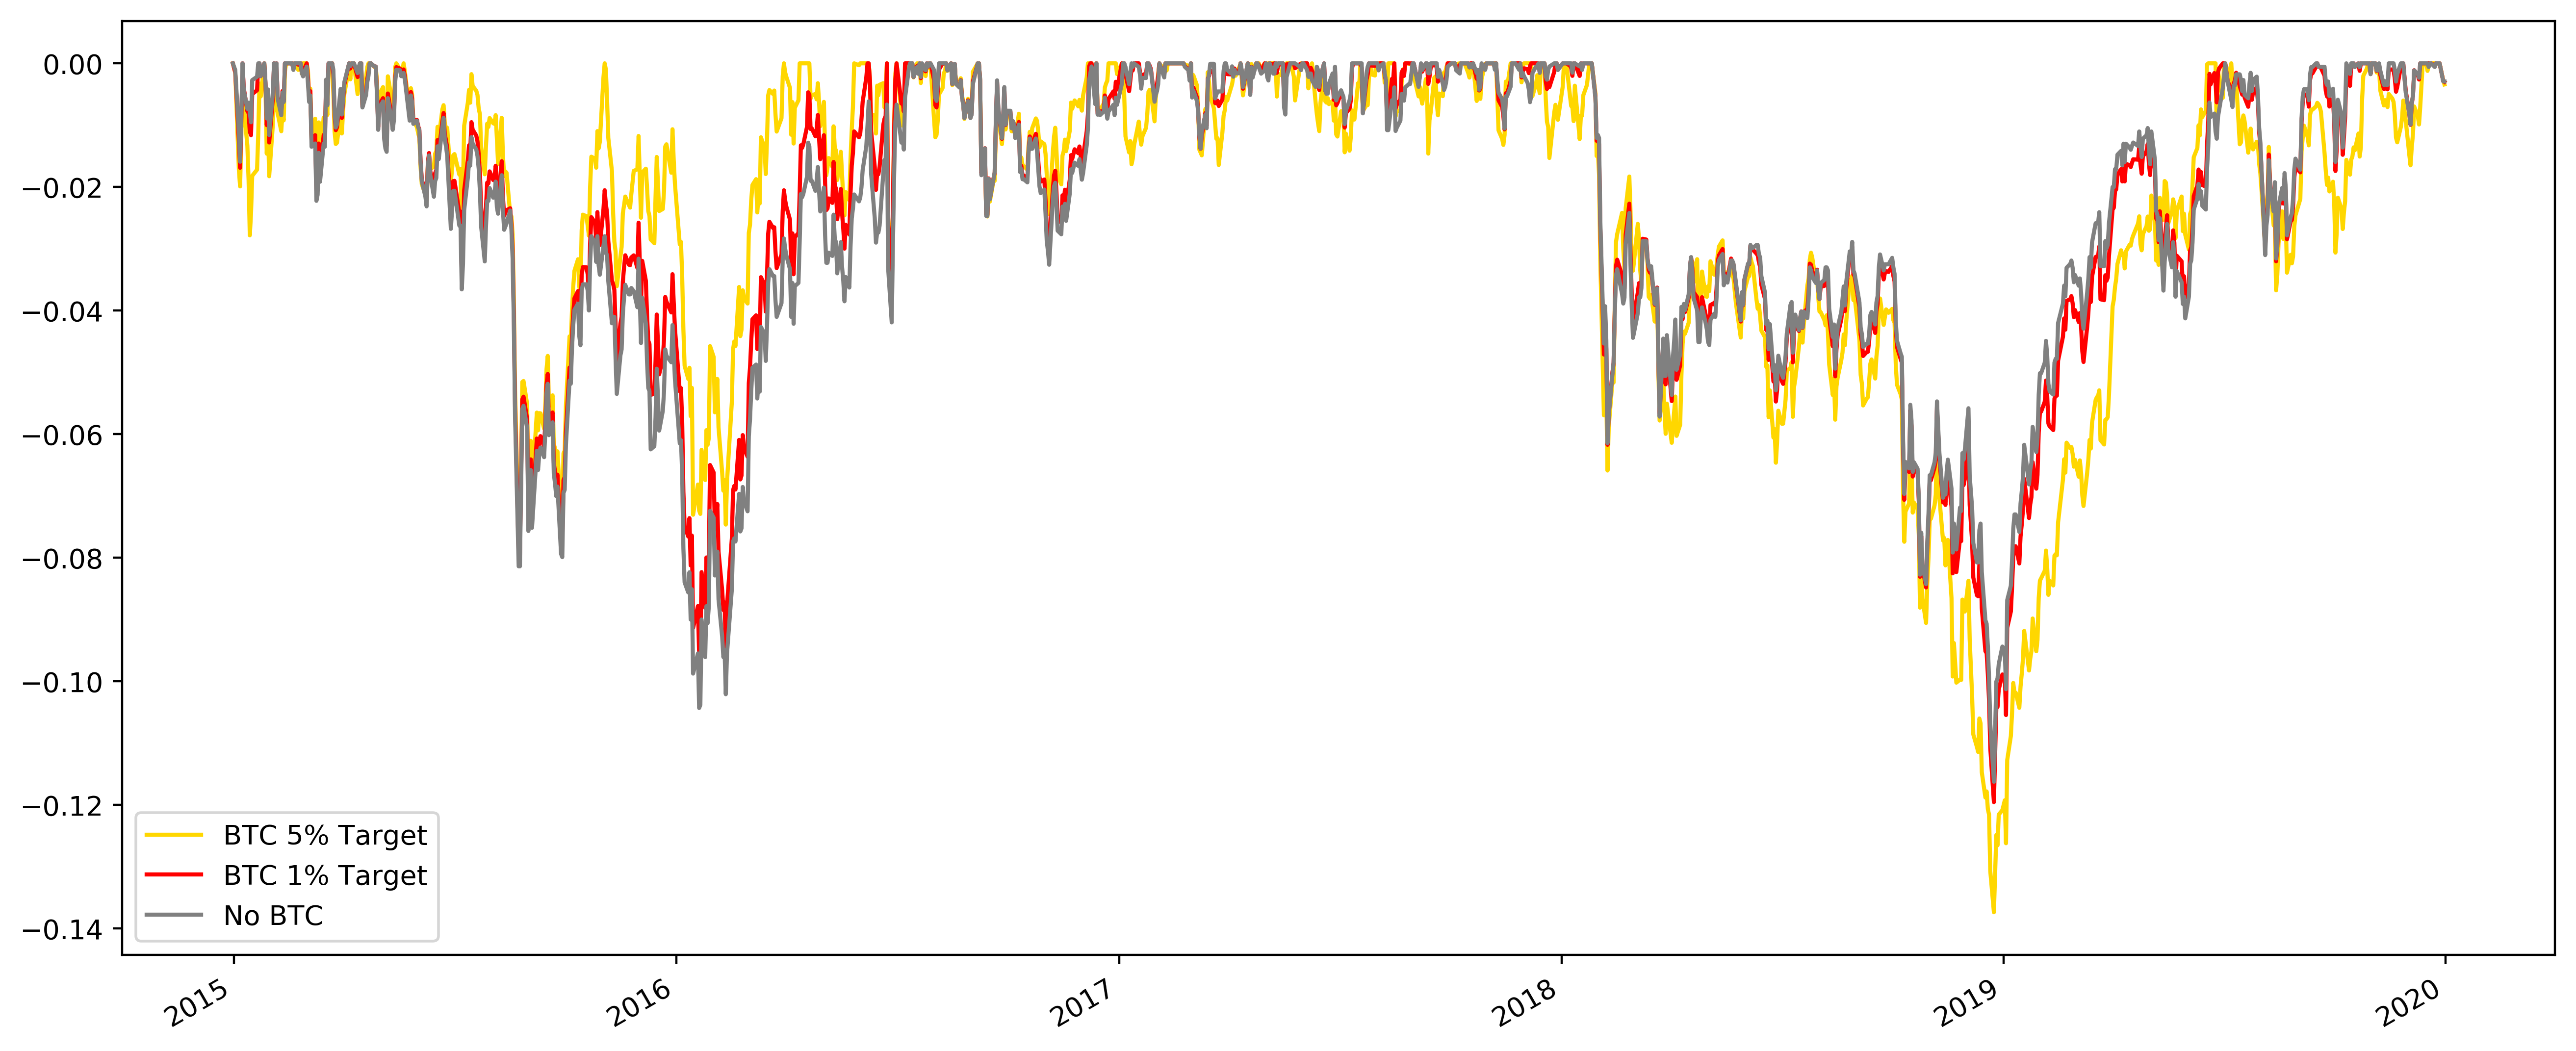

In [181]:
# Plot the results
fig, ax = plt.subplots(figsize=[16, 7])
Daily_Drawdown2.plot(color='gold', label='BTC 5% Target')
Daily_Drawdown1.plot(color='r', label='BTC 1% Target')
Daily_Drawdown3.plot(color='gray', label='No BTC')
plt.legend()
plt.show()

# Просто фонд Vanguard

In [191]:
# Список финансовых инструментов в портфеле
TIKERS = ['VPGDX']

# Данные которые будут использоваться в дальнейшем
COLUMNS = ['open', 'close', 'adjclose']

In [192]:
data = OrderedDict()

for tiker in TIKERS:
    data[tiker] = pd.read_csv("data/{}.csv".format(tiker), index_col=0, parse_dates=['date'])
    data[tiker] = data[tiker][COLUMNS]
    data[tiker] = data[tiker].resample("1d").mean()
    data[tiker].fillna(method="ffill", inplace=True)
    print(data[tiker].head())

                 open      close   adjclose
date                                       
2014-12-31  18.900000  18.900000  12.877502
2015-01-01  18.900000  18.900000  12.877502
2015-01-02  18.879999  18.879999  12.863875
2015-01-03  18.879999  18.879999  12.863875
2015-01-04  18.879999  18.879999  12.863875


In [193]:
for tiker in TIKERS:
    data[tiker]['close'] = data[tiker]['adjclose']
    data[tiker]['open'] = data[tiker]['adjclose']
    del data[tiker]['adjclose']
    print(data[tiker].tail())
COLUMNS = ['open', 'close']

                 open      close
date                            
2019-12-26  17.008001  17.008001
2019-12-27  17.040001  17.040001
2019-12-28  17.040001  17.040001
2019-12-29  17.040001  17.040001
2019-12-30  16.990000  16.990000


In [194]:
WEIGHTS = [1]
COMMISSION = 0.001

In [195]:
def initialize(context):
    
    context.set_commission(commission.PerDollar(cost=COMMISSION))
    
    context.tikers = TIKERS
    context.assets = [context.symbol(symbol) for symbol in context.tikers]
    
    context.weights = WEIGHTS
    context.n_assets = len(context.assets)
    
    context.window = 1
    
    context.rebalance_period = 1000000
    context.time = 0

In [196]:
def handle_data(context, data):
    
    # Закупка и ребаллансировка
    if context.time == 0 or (context.time % context.rebalance_period == 0):
        
        
        # submit orders
        for i, asset in enumerate(context.assets):
            order_target_percent(asset, context.weights[i])
            
    
    context.time += 1

In [197]:
perf = zipline.run_algorithm(start=datetime(2014, 12, 31, 0, 0, 0, 0, pytz.utc),
                              end=datetime(2019, 12, 31, 0, 0, 0, 0, pytz.utc),
                              initialize=initialize,
                              capital_base=10000000,
                              handle_data=handle_data,
                              data=panel)

In [198]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)

In [199]:
qf.get_performance_summary(returns)

annual_volatility     0.071391
annualized_returns    0.056969
cumulative_returns    0.318914
max_drawdown         -0.116266
sharpe_ratio          0.811899
sortino_ratio         1.128367
dtype: float64